In [1]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import wales_utils.data_cube_utilities.flooding as flooding

import datacube
dc = datacube.Datacube()

In 2020, Wales experienced some of the largest flooding on record. 
The sequencing, duration and severity of the rainfall in the catchment areas of Wales during February was of such intensity that many river levels reacted extremely quickly, reaching record levels and flows.
Records show 288mm of rain fell on average across Wales in February, but with some areas receiving up to four times the long-term monthly average.


For River Wye, Flood Warnings were issued on:
- 15 Feb (evening) - 17 Feb 2020
- 24 Feb - 25 Feb 2020
- 29 Feb - 01 Mar 2020
- 10 Mar 2020

For River Usk, Flood Alerts were issued on:
- 09 Feb - 10 Feb 2020
- 15 Feb (evening) - 18 Feb 2020
- 24 Feb - 25 Feb 2020
- 28 Feb  (evening) - 01 Mar 2020

For River Severn, Flood Warnings were issued on:
- 09 Feb - 10 Feb 2020
- 16 Feb - 17 Mar 2020
- 23 Feb - 25 Mar 2020
- 29 Feb 2020
- 10 Mar 2020

For River Dee, Flood Alerts were issued on:
- 09 Feb - 11 Feb 2020
- 13 Feb - 04 Mar 2020


## Query an area and period

#### Area

Please select one of the four rivers:
- 'wye'
- 'severn'
- 'dee'
- 'usk'



In [2]:
#  ENTER RIVER NAME
river = 'severn'

# select the above site
site = flooding.select_flooded_site(river)

Chosen area: Severn


#### Period

For this example, period of interest has been fixed to 01 Feb to 15 Mar 2020, which is the period of issued Flood Warnings/Alerts.

In [3]:
start_date = '2020-02-01'
end_date = '2020-03-15'

print("Analysed period: " + start_date + " to " + end_date)

Analysed period: 2020-02-01 to 2020-03-15


## Loading data from datacube 

#### Load data

In [4]:
# Preparing query for datacube
query = flooding.query_site_period(site, start_date, end_date)

# Let's load and clean a demo dasatet
dataset_in = dc.load(**query,
                    dask_chunks={'x': 1000, 'y': 1000})

# define nodata
dataset_in = dataset_in.where(dataset_in != 0)
# drop dates with only nodata for the area of interest
dataset_in = dataset_in.dropna('time', how='all')
# rename x and y with explicit names
dataset_in = dataset_in.rename({'x': 'longitude', 'y': 'latitude'})

# group images by YYYY-MM-DD
S1_dataset = dataset_in.groupby(dataset_in.time.dt.strftime("%Y-%m-%d")).mean("time")
S1_dataset = S1_dataset.rename({'strftime': 'date'})

print("Datacube ready")

Datacube ready


#### Have a look at the dataset structure

In [5]:
S1_dataset

<xarray.Dataset>
Dimensions:      (date: 27, latitude: 883, longitude: 1011)
Coordinates:
  * latitude     (latitude) float64 3.17e+05 3.17e+05 ... 3.082e+05 3.082e+05
  * longitude    (longitude) float64 3.219e+05 3.219e+05 ... 3.32e+05 3.32e+05
    spatial_ref  int32 27700
  * date         (date) object '2020-02-05' '2020-02-07' ... '2020-03-15'
Data variables:
    VH           (date, latitude, longitude) float32 dask.array<chunksize=(1, 883, 1000), meta=np.ndarray>
    VV           (date, latitude, longitude) float32 dask.array<chunksize=(1, 883, 1000), meta=np.ndarray>

#### Map Sentinel-1 VH backscatter (decibel) for each date of the period of interest

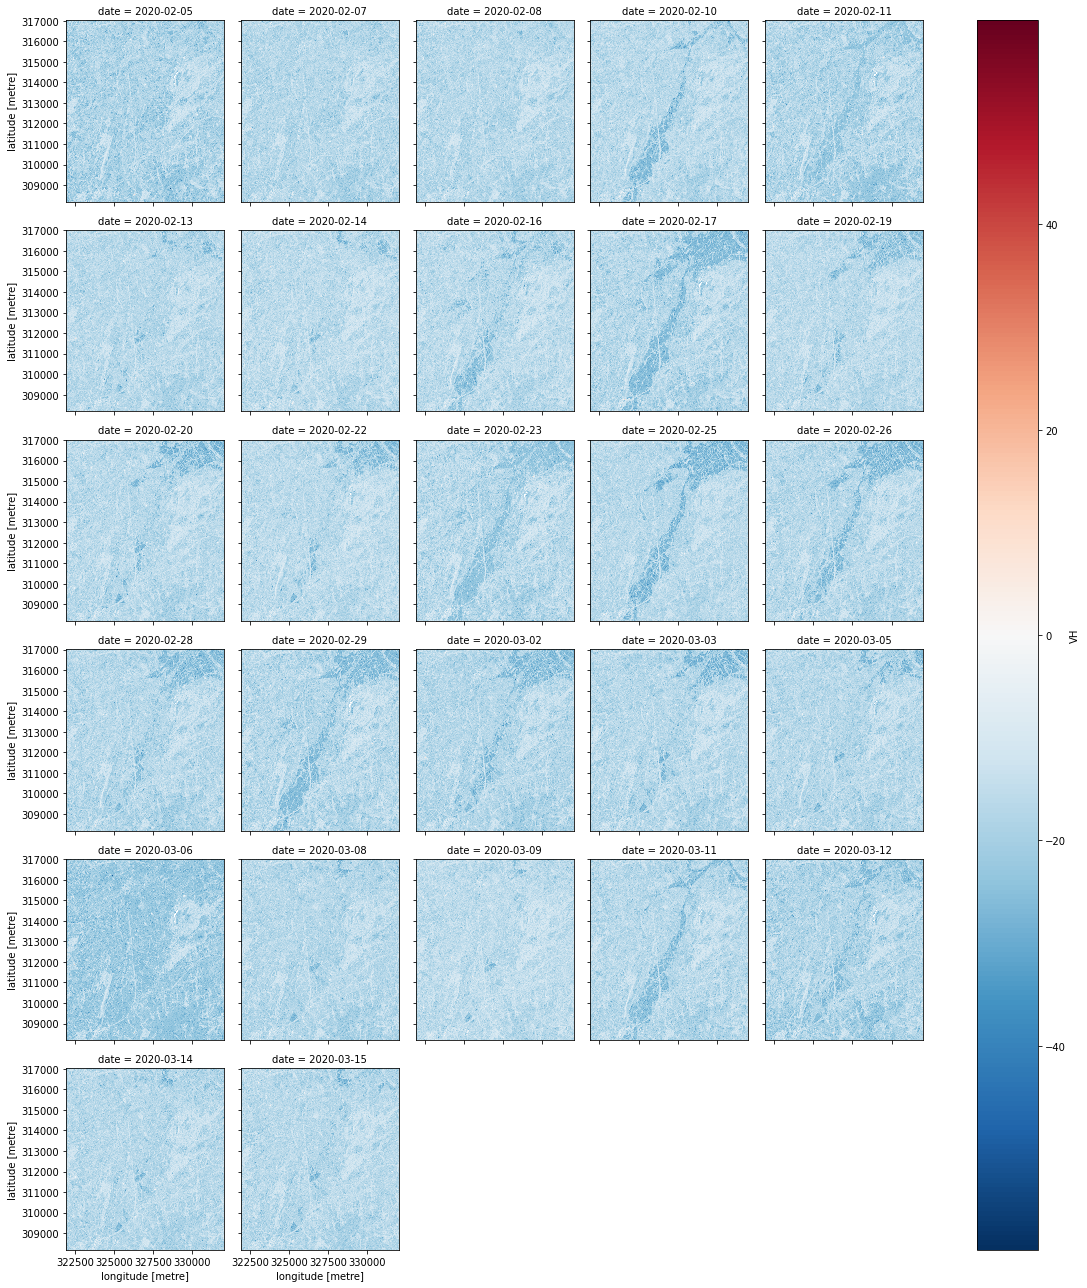

In [6]:
S1_dataset.VH.plot(col='date', col_wrap=5)

## Mapping flooded areas

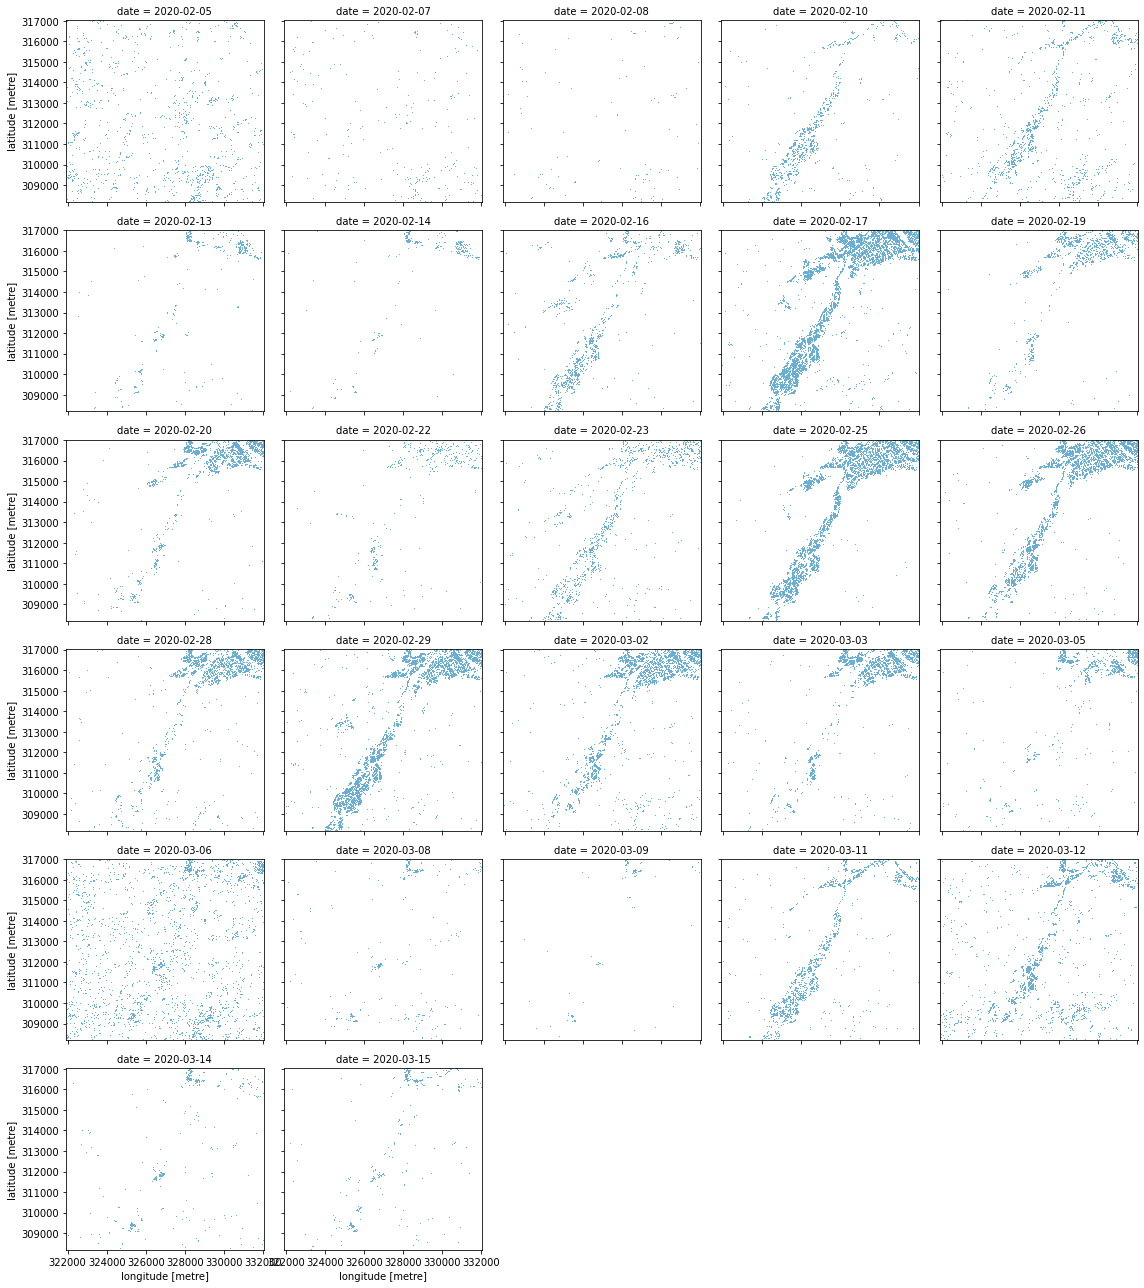

In [7]:
# Map flooded areas for each available Sentinel-1 scene
floods = flooding.flood_mapping(S1_dataset)

# Visualise flooded areas for each date
floods.plot(col='date', col_wrap=5, add_colorbar=False, cmap="Blues")

## Mapping progression of flood waters

Mapping the progression of the flood waters through the landscape in NRT during the whole period. This allows sensing of (1) newly flooded areas, (2) areas where flood waters have receded and (3) areas still flooded, for each consecutive date.


- RED: newly flooded areas since previous satellite imagery
- ORANGE: areas remaining flooded
- BLUE: areas where flood waters have receded since previous satellite imagery

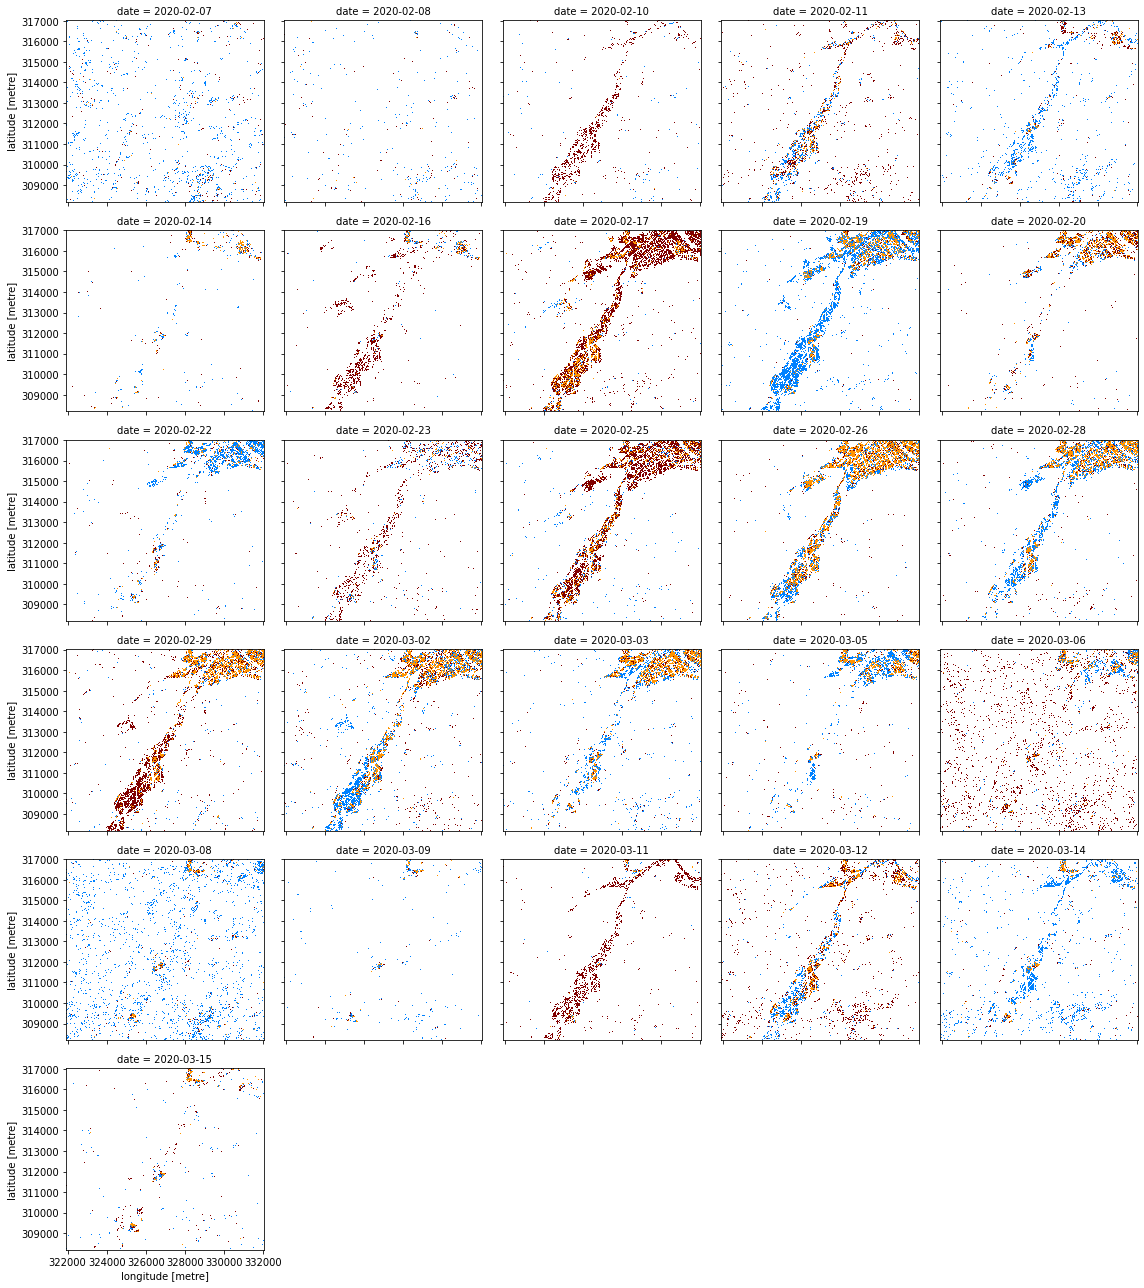

In [8]:
# Calculate water progression between each date of the studied period 
water_changes = flooding.flood_progression(floods)

# Visualise water progression between each date of the studied period 
water_changes.plot(col='date', col_wrap=5, cmap="jet", add_colorbar=False)

## Calculate how frequently each pixel was observed as wet during February 2020

Text(0.5, 1.0, 'Water frequency during February 2020')

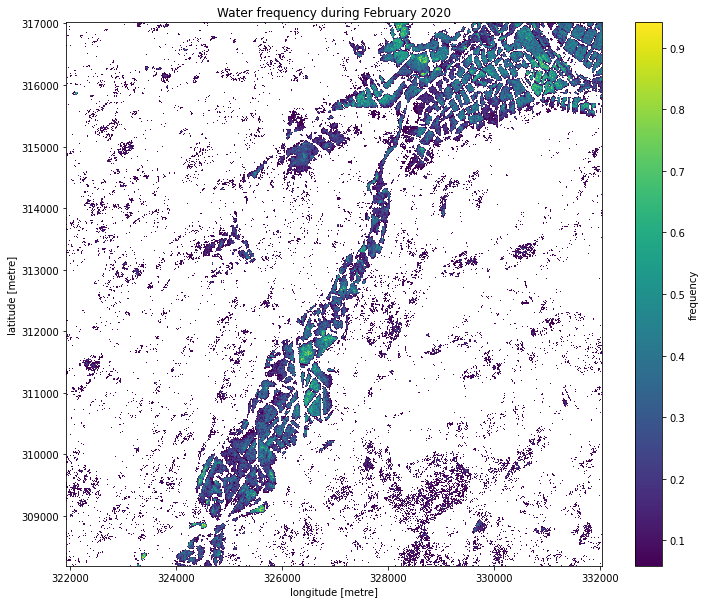

In [9]:
# Calculate water frequency during February 2020
frequency = flooding.flood_frequency(floods, '2020-02-01', '2020-02-29')

# Visualise water frequency during February 2020
frequency.plot(figsize=(12,10))
plt.title('Water frequency during February 2020')